# This notebook loads and evaluates prepared dataset

In [2]:
import os
import pandas as pd
import pysrc.review.config as cfg

root = os.path.expanduser(cfg.dataset_path)
print('Dataset folder', root)

Dataset folder /home/student/review/dataset


In [4]:
abstracts_df = pd.read_csv(os.path.join(root, "abstracts.csv"), sep='\t')

In [5]:
sents_df = pd.read_csv(os.path.join(root, "sentences.csv"), sep='\t')

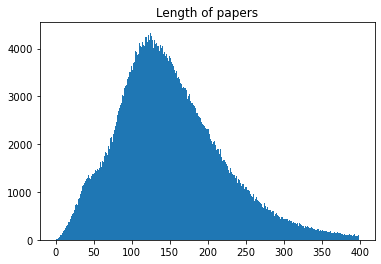

In [7]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter

res = Counter(list(sents_df['pmid'].values))

plt.hist(res.values(), bins=range(-1, 400))
plt.title('Length of papers')
plt.show()

In [8]:
from operator import itemgetter

min_key, min_count = min(res.items(), key=itemgetter(1))
print(min_key, min_count)

18995172 1


In [9]:
max_key, max_count = max(res.items(), key=itemgetter(1))
print(max_key, max_count)

21994484 5095


In [10]:
sents_df[sents_df['pmid'] == 18995172]['sentence'].values

array(['This special Symposium-in-Print issue of Bioorganic & Medicinal Chemistry Letters commemorates the 2008 Tetrahedron Young Investigator Award in Bioorganic & Medicinal Chemistry awarded to Benjamin F. Cravatt.'],
      dtype=object)

In [11]:
sents_df[sents_df['pmid'] == 21994484]['sentence'].values[:100]

array(['Hypocrea/Trichoderma is a taxonomically difficult, hyperdiverse genus with an extraordinarily high number of species, similar to Fusarium sensu lato.',
       'While in Fusarium the high species number is in part due to a heterogeneous assemblage of species based on the morphologically easily recognisable shape of macroconidia ( xref_bibr_R5 ), and Fusarium sensu stricto is more or less highly specialised to host plants ( xref_bibr_R57 ; xref_bibr_R46 ), the high diversity in Hypocrea/Trichoderma is a result of its hyperparasitic life style on other fungi. xref_bibr_R36 treated several aspects of the genus Hypocrea/Trichoderma, including the taxonomic history of the teleomorph genus Hypocrea and the anamorph genus Trichoderma, the development of the species concept, and important economic and social aspects.',
       'He explained the strategy of species identification and recognition followed in the underlying project.',
       'The project was designed to study the diversity 